Exploratory Data Analysis

This is part one of the Automatic Essay Scoring where it covers exploratory data analysis, grammar and spelling correction as well as some feature extraction using SpaCy

This notebook is a requirement for CS160P which explores machine learning algorithms with vectorized features from all student essay tests.


The processing of each essay will include the following:
-Language correction with languagetool (add number of corrections as feature) with TextBlob and Language Tool Python
-Sentence tokenization with Spacy 
-Sentence count and length
-Word tokenize with Spacy
-Word token classification (punctuation, stop words and anonymized entities, pos, ent)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_check
from textblob import TextBlob

from sklearn.model_selection import train_test_split


plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)


import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
5405,8959,4,"In this short story, Saeng vows to take the test again in the spring because she knows that she ...",3,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
topic             12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
target_score      12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
topic2_target     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

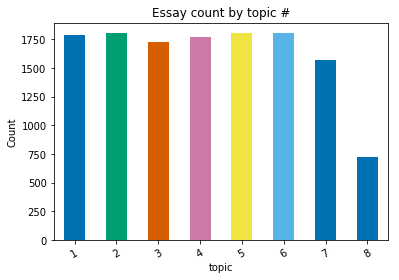

In [4]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [5]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

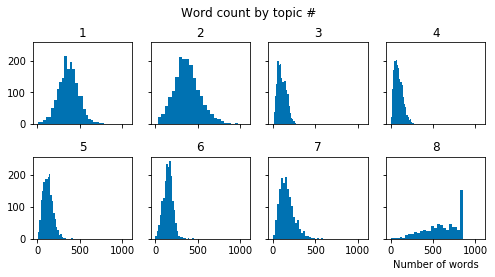

In [6]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:
#use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save to pickle
training_set.to_pickle('training_corr.pkl')

Processing time: 0:14:07.330476


In [17]:
training_set = pd.read_pickle('training_corr.pkl')

In [18]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation)

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()


for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        #add blank in case parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:10:03.031798


In [19]:
training_set.to_pickle('training_spacy.pkl')

In [20]:
training_set = pd.read_pickle('training_spacy.pkl')

In [21]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, VERB, ADP, NOUN, VERB, ADJ, NOUN, NOUN, SYM, NOU...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...","[Facebook, MySpace, all day]"
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[ADJ, PROPN, PUNCT, PUNCT, PRON, VERB, ADP, VERB, NOUN, VERB, VERB, PRON, ADP, ADJ, NOUN, ADP, V...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[Facebook, MySpace, millions, one, MySpace, Facebook, one, millions, @MONTH1, @LOCATION2, A Mill..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[ADJ, PUNCT, PROPN, PUNCT, PROPN, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, ADV, NOUN, VE...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[today, one, @CAPS4, one, @MONTH1, thousand, @ORGANIZATION1]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[ADJ, PROPN, PROPN, PUNCT, PROPN, PRON, VERB, VERB, ADP, ADJ, NOUN, VERB, ADP, NOUN, VERB, ADV, ...","[Dear Local Newspaper, @CAPS1, I have found that many experts say that computers do not benefit ...","[Dear Local Newspaper, @PERSON1, @PERSON2, @CAPS4, @LOCATION2, @PERCENT3, @LOCATION1, A+, Newspa..."
4,"[Dear, @LOCATION1, ,, I, know, having, computers, has, a, positive, effect, on, people, ., The, ...","[ADJ, ADP, PUNCT, PRON, VERB, VERB, NOUN, VERB, DET, ADJ, NOUN, ADP, NOUN, PUNCT, DET, NOUN, VER...","[Dear @LOCATION1, I know having computers has a positive effect on people., The computers connec...","[First, @NUM1 hours, one, Mae, Secondly, @LOCATION2, one, one]"
